1.  Проведем DESeq2 нормализацию сырых данных экспрессий:

out of 49741 with nonzero total read count

adjusted p-value < 0.1

LFC > 0 (up)       : 18, 0.036%

LFC < 0 (down)     : 75, 0.15%

outliers [1]       : 0, 0%

low counts [2]     : 25412, 51%

(mean count < 2)

 анализ проводился по 49,741 генам, у которых хотя бы в одном образце есть ненуловое количество чтений,

 LFC > 0 (up) — 18 генов (0.036%) имеют логарифм fold change > 0, т.е. они повышены у R по сравнению с NR.

LFC < 0 (down) — 75 генов (0.15%) имеют логарифм fold change < 0, т.е. они понижены у R по сравнению с NR.

Всего 93 гена (18 + 75) считаются значимо дифференциально экспрессированными при пороге FDR < 0.1.

outliers: 0 (0%) — никаких генов не было исключено как выбросы в модели.

25412 (51%) генов имеют среднее количество чтений < 2 и помечены как "низкоэкспрессированные".

Они могут быть не информативны для анализа

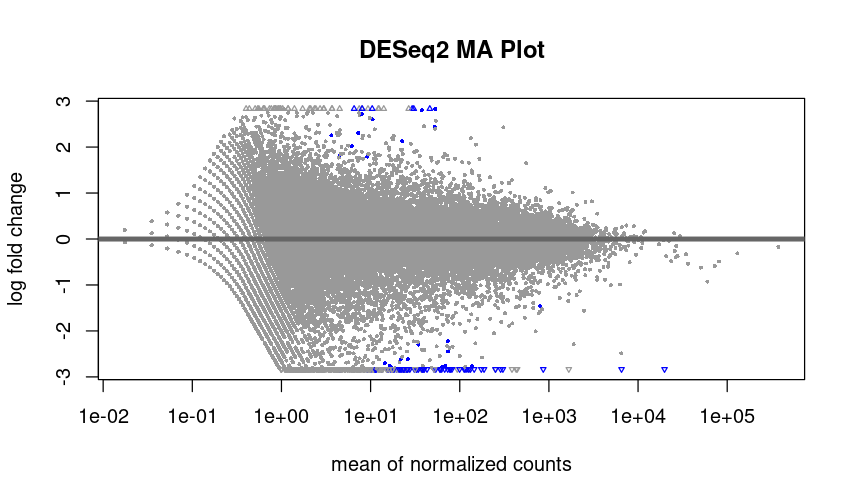

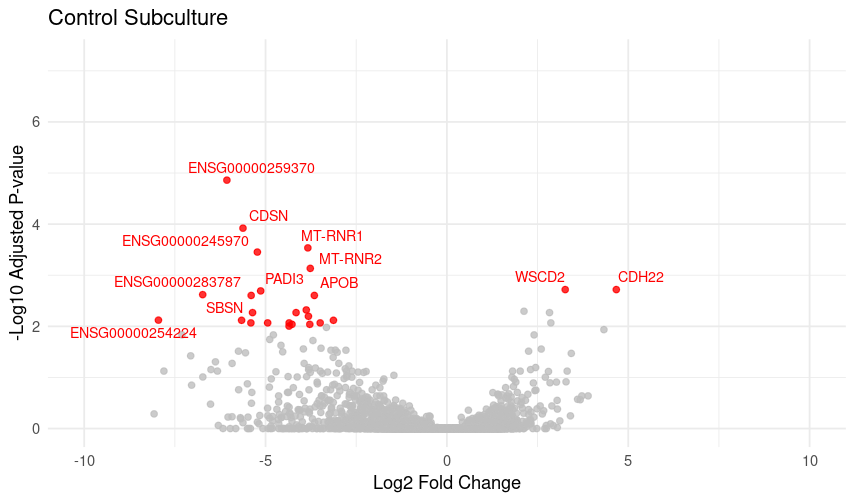

2. Построим PCA на DESeq2 нормализованных каунтах, для этого допишем код:

In [ ]:
vsd <- vst(dds, blind = TRUE)
pcaData <- plotPCA(vsd, intgroup = "X0", returnData = TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))

ggplot(pcaData, aes(PC1, PC2, color = X0)) +
  geom_point(size = 3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  coord_fixed() +
  theme_minimal() +
  labs(title = "PCA of ICI samples")


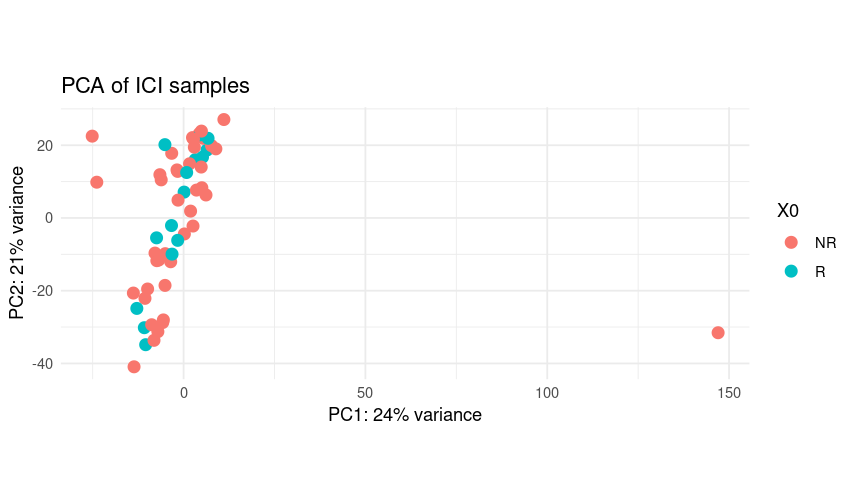

Проанализируем и посмотрим есть ли batch-эффект:

Batch-эффект — это небиологическое систематическое отличие между группами образцов, возникающее в результате технических факторов, а не из-за интересующего биологического различия

Первая компонента объясняет 24%, вторая - 21%.  Среди NR - есть выбросы, возможно, по причине batch-эффекта.

Построим clustermap образцов:

In [ ]:
mat <- assay(vsd)

# 3. Рассчитаем расстояния между образцами по корреляции Пирсона (1 - кор)
sampleDists <- dist(t(mat))  # или используем 1 - cor для более точной меры

# Альтернативный способ: использовать расстояния 1 - кор
library(corrplot)
cor_mat <- cor(mat)
sampleDists <- as.dist(1 - cor_mat)

# 4. Добавим аннотации (если есть метаданные)
annotation_col <- as.data.frame(colData(dds)[, c("X0")])  # например, биологическая группа
colnames(annotation_col) <- "Group"

# 5. Построим clustermap
pheatmap(mat,
         cluster_rows = TRUE,
         cluster_cols = TRUE,
         annotation_col = annotation_col,
         show_rownames = FALSE,
         fontsize_col = 10,
         main = "Clustermap of samples")

3. Удалим из датасета гены, медианная экспрессия которых меньше 0.25 квартили всех медианных экспрессий.

In [ ]:
# 1. Посчитаем медиану экспрессии по строкам (по каждому гену)
gene_medians <- apply(mat, 1, median)

# 2. Найдём 25-й перцентиль (порог отсечения)
q1_threshold <- quantile(gene_medians, 0.25)

# 3. Отфильтруем гены с медианной экспрессией >= Q1
filtered_mat <- mat[gene_medians >= q1_threshold, ]

Построим PCA на отфильтрованных данных:


In [ ]:
pca <- prcomp(t(filtered_mat), scale. = TRUE)

# Собираем dataframe с PCA + группами
pca_df <- as.data.frame(pca$x)
pca_df$Group <- colData(dds)$X0


# Строим PCA
ggplot(pca_df, aes(x = PC1, y = PC2, color = Group)) +
  geom_point(size = 3) +
  theme_minimal() +
  labs(title = "PCA on Filtered Genes",
       x = paste0("PC1 (", round(summary(pca)$importance[2,1]*100, 1), "%)"),
       y = paste0("PC2 (", round(summary(pca)$importance[2,2]*100, 1), "%)"))

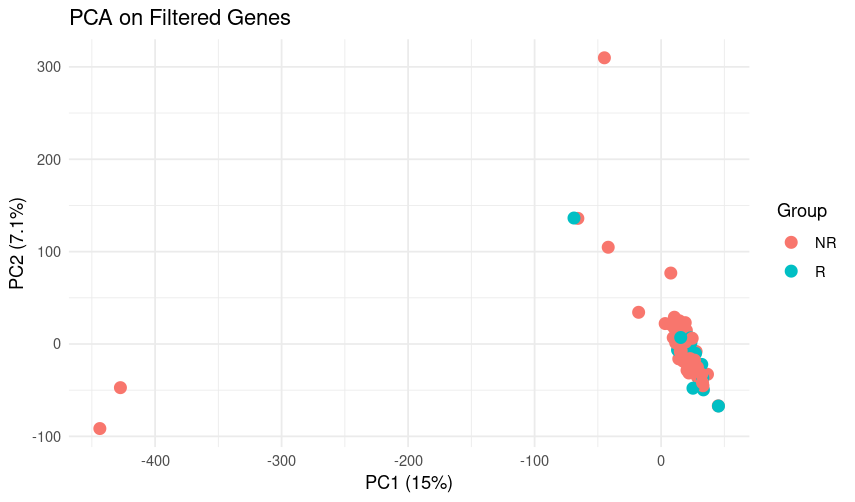

Проведем анализ дифференциально экспрессированных генов (получите таблицу с p value и fold change):


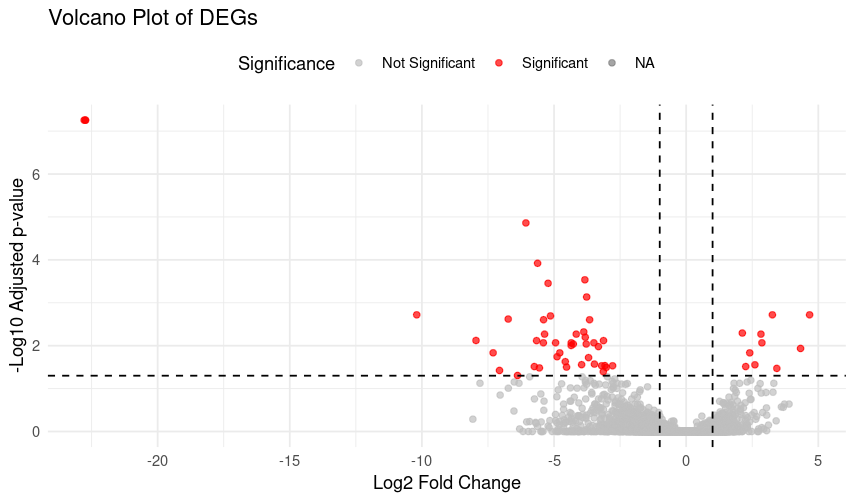